In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import skimage
import matplotlib as mpl
from torch.fft import fft2, ifft2, fftshift
from tqdm.notebook import tqdm
import scipy
from wavefront import Wavefront
from probe import get_triangle_mask
import helper

In [3]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

### Simulating phase object

In [15]:
obj_phase = skimage.data.camera() * 1.0 / 255 - 0.5

In [16]:
obj_arr = np.exp(1j * obj_phase)
obj_true = torch.tensor(obj_arr)

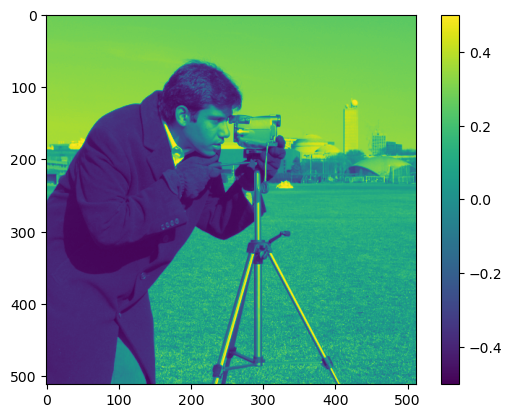

In [17]:
plt.imshow(np.angle(obj_arr))
plt.colorbar()

### Setting up the probe

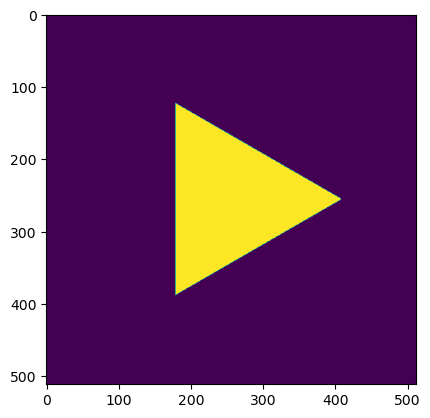

In [18]:
mask = get_triangle_mask()
plt.imshow(mask)
plt.show()

In [19]:
gaussian_1d = scipy.signal.windows.gaussian(512, 50)
gaussian_2d = gaussian_1d[:,None] * gaussian_1d[None, :]

In [20]:
probe_input = Wavefront(torch.tensor(gaussian_2d, dtype=torch.complex64)).fftshift()
mask_tensor = torch.tensor(mask, dtype=torch.complex64)

In [21]:
probe_plane1_true = probe_input.obj_mult(mask_tensor)

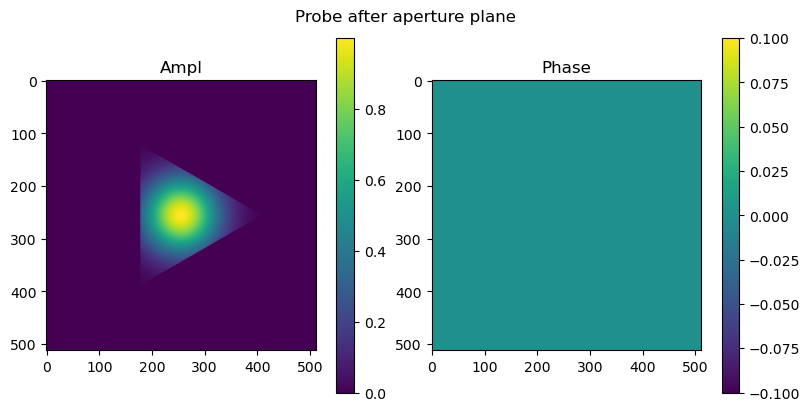

In [22]:
helper.plot2(probe_plane1_true, suptitle='Probe after aperture plane')

In [47]:
probe_plane2_true, transfer_function = probe_plane1_true.prop_nearfield(1e-4, wavelength=0.25e-9,  pixel_size=[10e-6 / 512, 10e-6 / 512], 
                                                                        return_transfer_function=True)

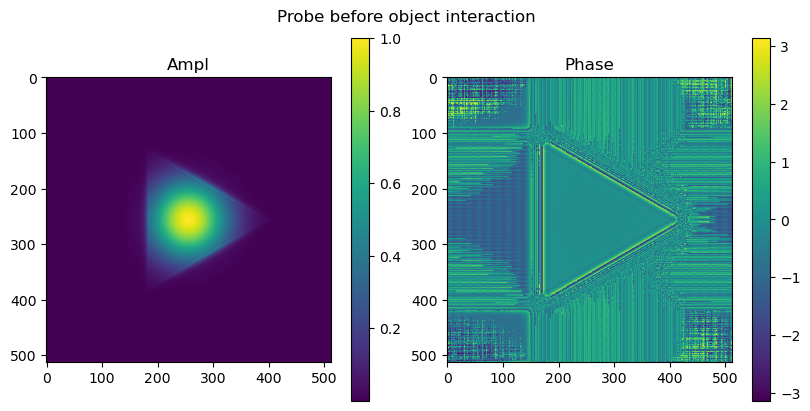

In [24]:
helper.plot2(probe_plane2_true, suptitle='Probe before object interaction')

In [25]:
exit_wave_plane2 = probe_plane2_true.obj_mult(obj_true)

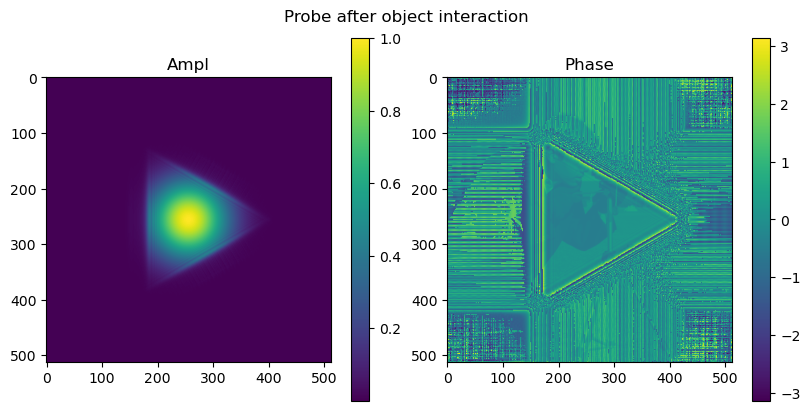

In [27]:
helper.plot2(exit_wave_plane2, suptitle='Probe after object interaction')

In [28]:
farfield_true = exit_wave_plane2.prop_farfield()

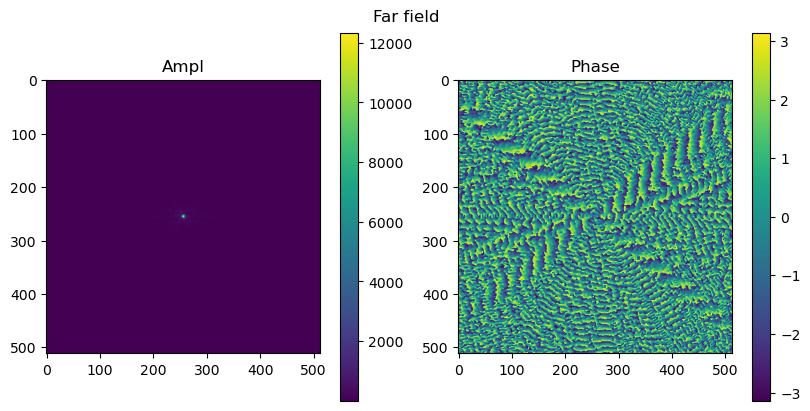

In [30]:
helper.plot2(farfield_true, suptitle='Far field')

In [34]:
# Testing the compressed forward model

probe_plane2_guess = helper.plane1_forward_model
farfield_amps_true = helper.plane2_forward_model(obj_guess=obj_true, probe_plane2=probe_plane2_true).fftshift().amplitude

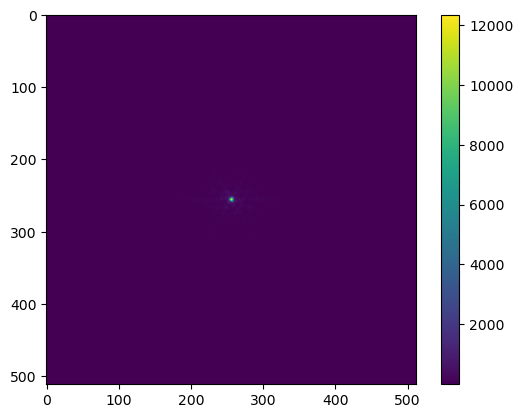

In [35]:
plt.imshow(farfield_amps_true.cpu())
plt.colorbar()

### Phase retrieval with probe fixed

Since we know the true probe, we dont need to care about the propagation from the aperture to the object plane.

In [37]:
# Creating the probe by propagating the triangle to 1mm
# object/probe size at object plane is 10 um x 10 um
# Object/probe is 512 x 512 pix.
# wavelength is 5 kev

prop_dist = 1e-4 # 1 mm
pixel_size = [10e-6 / 512, 10e-6 / 512]
wavelength = 0.25e-9

In [38]:
obj_guess = torch.ones_like(obj_true, requires_grad=True)

In [39]:
optimizer = torch.optim.Adam(params=[obj_guess], lr=5e-4)

In [40]:
losses = []

In [41]:
N_EPOCHS = 5000

In [42]:
# actual optimization
for epoch in range(N_EPOCHS):
    optimizer.zero_grad()
    
    obj_constrained = helper.amplitude_constraint(obj_guess)
    #obj_constrained = obj_guess
    guess_amps = helper.plane2_forward_model(obj_constrained, probe_plane2_true).fftshift().amplitude
    loss = helper.loss_fn(guess_amps, farfield_amps_true)
    losses.append(loss.detach().cpu().numpy())
    loss.backward()
    optimizer.step()
    
    

In [43]:
obj_final = obj_guess.detach().cpu().numpy()

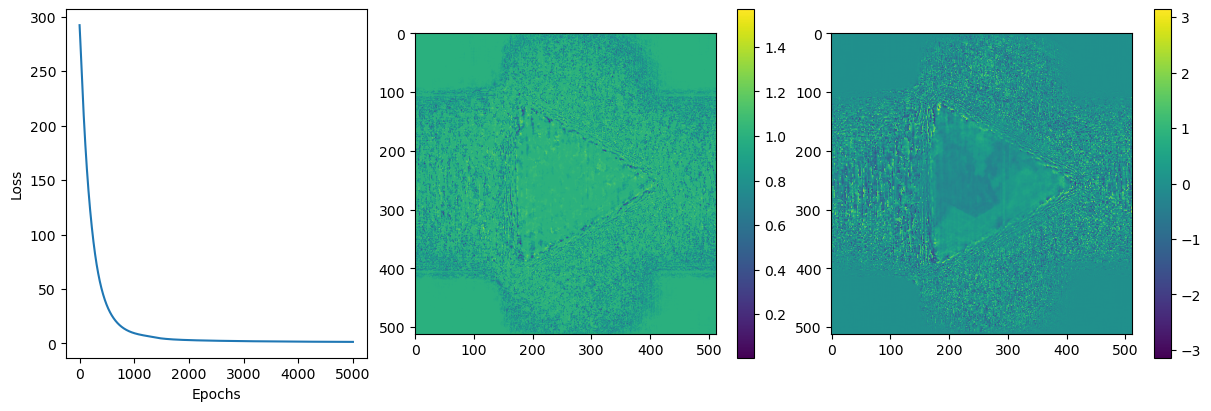

In [44]:
fig, axs = plt.subplots(1,3,figsize=[12,4], constrained_layout=True)
plt.subplot(1,3,1)
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1,3,2)
plt.imshow(np.abs(obj_final))
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(np.angle(obj_final))
plt.colorbar()


In [45]:
# THis does not work very well!

###  Probe + object retrieval

In [104]:
mask_tensor = torch.tensor(mask.astype('complex64'))
probe_plane1_guess_tensor = fftshift(mask_tensor).clone().detach().requires_grad_(True)
probe_plane1_guess = Wavefront(probe_plane1_guess_tensor)

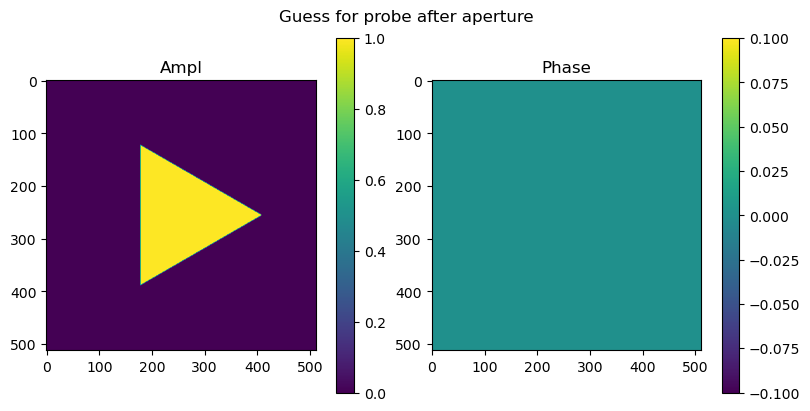

In [105]:
helper.plot2(Wavefront(mask_tensor).fftshift(), suptitle='Guess for probe after aperture')

In [106]:
obj_guess = torch.ones_like(obj_true, requires_grad=True)

In [107]:
optimizer = torch.optim.Adam(params=[obj_guess, probe_plane1_guess_tensor], lr=5e-4)

In [108]:
losses = []

In [109]:
N_EPOCHS = 5000

In [110]:
# actual optimization
for epoch in range(N_EPOCHS):
    optimizer.zero_grad()
    
    obj_constrained = helper.amplitude_constraint(obj_guess)
    probe_plane1_constrained = helper.plane1_constraint(probe_plane1_guess, mask_tensor)
    probe_plane2_guess = probe_plane1_constrained.prop_nearfield(1e-4, wavelength=wavelength,  pixel_size=pixel_size,
                                                                 transfer_function=transfer_function)
    #obj_constrained = obj_guess
    guess_amps = helper.plane2_forward_model(obj_constrained, probe_plane2_guess).fftshift().amplitude
    loss = helper.loss_fn(guess_amps, farfield_amps_true)
    losses.append(loss.detach().cpu().numpy())
    loss.backward()
    optimizer.step()
    
    

In [111]:
obj_final = obj_constrained.detach().cpu().numpy()

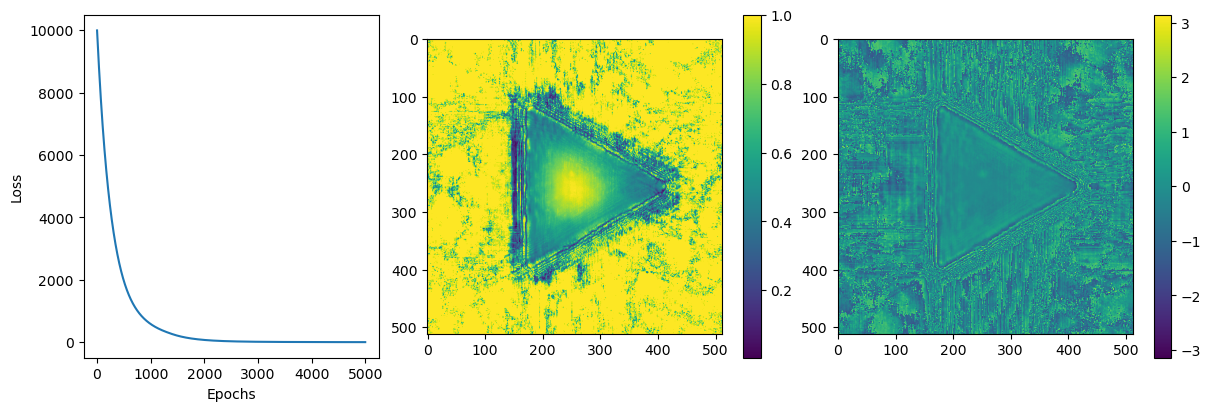

In [112]:
fig, axs = plt.subplots(1,3,figsize=[12,4], constrained_layout=True)
plt.subplot(1,3,1)
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1,3,2)
plt.imshow(np.abs(obj_final))
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(np.angle(obj_final))
plt.colorbar()


In [113]:
probe_final = Wavefront(probe_plane1_constrained.tensor.detach())

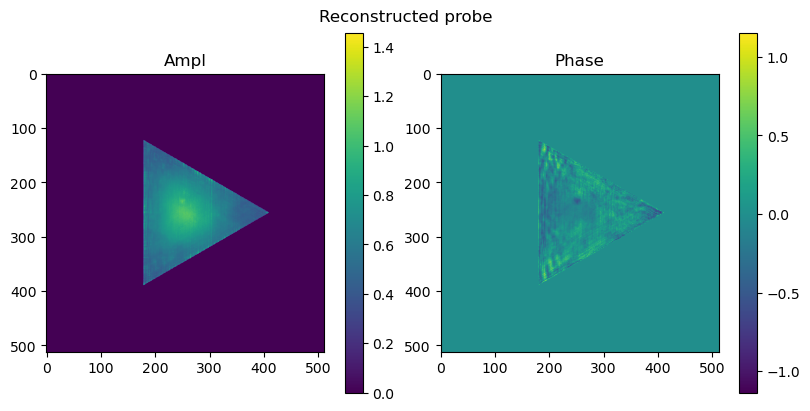

In [114]:
helper.plot2(probe_final, suptitle='Reconstructed probe')